## **Import Dependencies**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm

In [16]:
original_data = "dataset/Original"
augmented_data = "dataset/augmented-data"
img_size = 224
batch_size = 8

## **Load and Preprocess Data**

In [17]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

original_dataset = ImageFolder(original_data, transform=transform)
augmented_dataset = ImageFolder(augmented_data, transform=transform)
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

train_size = int(0.8 * len(combined_dataset))
val_size = int(0.1 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - val_size

train_subset, val_subset, test_subset = torch.utils.data.random_split(
    combined_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size)
test_loader = DataLoader(test_subset, batch_size=batch_size)

print(f"Train Size: {len(train_loader.dataset)}")
print(f"Val Size: {len(val_loader.dataset)}")
print(f"Test Size: {len(test_loader.dataset)}")

Train Size: 1854
Val Size: 231
Test Size: 233


In [18]:
class_names = original_dataset.classes
num_classes = len(class_names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")
print("Number of Classes", num_classes)
print(f"Classes: {class_names}")

Device: cuda
Number of Classes 2
Classes: ['no', 'yes']


## **Hepler Functions for Training and Evaluation**

In [19]:
from tqdm.notebook import tqdm
import torch

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, writer, num_epochs=10, model_name="model"):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in tqdm(range(num_epochs), desc="Training Progress", position=0):
        model.train()
        train_loss, train_correct = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Batches", leave=False, position=1):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data).item()

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data).item()

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_val_loss   = val_loss / len(val_loader.dataset)
        epoch_train_acc  = train_correct / len(train_loader.dataset)
        epoch_val_acc    = val_correct / len(val_loader.dataset)

        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_acc"].append(epoch_train_acc)
        history["val_acc"].append(epoch_val_acc)

        writer.add_scalar(f"{model_name}/train_loss", epoch_train_loss, epoch)
        writer.add_scalar(f"{model_name}/val_loss", epoch_val_loss, epoch)
        writer.add_scalar(f"{model_name}/train_acc", epoch_train_acc, epoch)
        writer.add_scalar(f"{model_name}/val_acc", epoch_val_acc, epoch)

        print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc:.4f}, Val Loss={epoch_val_loss:.4f}, Val Acc={epoch_val_acc:.4f}")

        scheduler.step(epoch_val_loss)

    return model, history

In [20]:
def plot_curves(history, model_name):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.title(f"{model_name} Accuracy")
    plt.legend()
    plt.show()

In [21]:
def evaluate_model(model, test_loader, model_name):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    acc = np.mean(np.array(y_true) == np.array(y_pred))
    pre = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"{model_name} Test Accuracy: {acc:.4f}")
    print(f"{model_name} Test Precision: {pre:.4f}")
    print(f"{model_name} Test Recall: {rec:.4f}")
    print(f"{model_name} Test F1-Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    return acc, pre, rec, f1

In [31]:
def get_model(model_name, num_classes):
    if model_name == "mobilenet":
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[0] = nn.Dropout(p=0.5)
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    elif model_name == "vgg19":
        model = models.vgg19(pretrained=False)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == "densenet":
        model = models.densenet121(pretrained=False)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == "resnet":
        model = models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "vit":
        model = models.vit_b_16(pretrained=False)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    else:
        raise ValueError("Unknown model name")
    return model.to(device)

## **Train the Models**

In [23]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
results = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []}

### **Train Mobilenet**

Training Mobilenet...


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.6157, Train Acc=0.6850, Val Loss=0.5209, Val Acc=0.7446


Epoch 2/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.5300, Train Acc=0.7384, Val Loss=0.5410, Val Acc=0.7922


Epoch 3/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.4827, Train Acc=0.7832, Val Loss=0.4082, Val Acc=0.8355


Epoch 4/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.4235, Train Acc=0.8150, Val Loss=0.3809, Val Acc=0.8139


Epoch 5/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.3884, Train Acc=0.8382, Val Loss=0.2545, Val Acc=0.8831


Epoch 6/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.3582, Train Acc=0.8511, Val Loss=0.2927, Val Acc=0.8831


Epoch 7/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.3270, Train Acc=0.8571, Val Loss=0.2502, Val Acc=0.8874


Epoch 8/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.3196, Train Acc=0.8749, Val Loss=0.2556, Val Acc=0.8831


Epoch 9/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.2968, Train Acc=0.8770, Val Loss=0.3181, Val Acc=0.8571


Epoch 10/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.2950, Train Acc=0.8792, Val Loss=0.2159, Val Acc=0.9134


Epoch 11/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.2958, Train Acc=0.8808, Val Loss=0.2293, Val Acc=0.9091


Epoch 12/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.2368, Train Acc=0.9099, Val Loss=0.2831, Val Acc=0.8874


Epoch 13/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.2617, Train Acc=0.9008, Val Loss=0.1499, Val Acc=0.9351


Epoch 14/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.2063, Train Acc=0.9202, Val Loss=0.1398, Val Acc=0.9524


Epoch 15/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.2068, Train Acc=0.9180, Val Loss=0.1347, Val Acc=0.9524


Epoch 16/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.2499, Train Acc=0.9051, Val Loss=0.1914, Val Acc=0.8961


Epoch 17/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.2062, Train Acc=0.9218, Val Loss=0.2503, Val Acc=0.9048


Epoch 18/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.2049, Train Acc=0.9218, Val Loss=0.1855, Val Acc=0.9091


Epoch 19/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.2011, Train Acc=0.9245, Val Loss=0.0897, Val Acc=0.9784


Epoch 20/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.2207, Train Acc=0.9207, Val Loss=0.1008, Val Acc=0.9610


Epoch 21/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.1935, Train Acc=0.9277, Val Loss=0.1653, Val Acc=0.9307


Epoch 22/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.1940, Train Acc=0.9396, Val Loss=0.2134, Val Acc=0.8961


Epoch 23/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.1824, Train Acc=0.9347, Val Loss=0.2119, Val Acc=0.9177


Epoch 24/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 24: Train Loss=0.1434, Train Acc=0.9531, Val Loss=0.0732, Val Acc=0.9913


Epoch 25/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.0846, Train Acc=0.9725, Val Loss=0.0435, Val Acc=0.9870


Epoch 26/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 26: Train Loss=0.0800, Train Acc=0.9822, Val Loss=0.0515, Val Acc=0.9784


Epoch 27/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 27: Train Loss=0.0723, Train Acc=0.9773, Val Loss=0.0445, Val Acc=0.9957


Epoch 28/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 28: Train Loss=0.0704, Train Acc=0.9811, Val Loss=0.0385, Val Acc=0.9913


Epoch 29/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 29: Train Loss=0.0486, Train Acc=0.9876, Val Loss=0.0314, Val Acc=0.9913


Epoch 30/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 30: Train Loss=0.0588, Train Acc=0.9838, Val Loss=0.0305, Val Acc=0.9870


Epoch 31/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 31: Train Loss=0.0566, Train Acc=0.9827, Val Loss=0.0329, Val Acc=0.9913


Epoch 32/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 32: Train Loss=0.0494, Train Acc=0.9849, Val Loss=0.0100, Val Acc=1.0000


Epoch 33/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 33: Train Loss=0.0351, Train Acc=0.9908, Val Loss=0.0193, Val Acc=0.9957


Epoch 34/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 34: Train Loss=0.0316, Train Acc=0.9898, Val Loss=0.0096, Val Acc=1.0000


Epoch 35/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 35: Train Loss=0.0341, Train Acc=0.9919, Val Loss=0.0176, Val Acc=0.9957


Epoch 36/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 36: Train Loss=0.0323, Train Acc=0.9919, Val Loss=0.0252, Val Acc=0.9913


Epoch 37/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 37: Train Loss=0.0435, Train Acc=0.9865, Val Loss=0.0183, Val Acc=0.9957


Epoch 38/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 38: Train Loss=0.0222, Train Acc=0.9946, Val Loss=0.0107, Val Acc=1.0000


Epoch 39/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 39: Train Loss=0.0256, Train Acc=0.9914, Val Loss=0.0299, Val Acc=0.9870


Epoch 40/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 40: Train Loss=0.0209, Train Acc=0.9919, Val Loss=0.0085, Val Acc=1.0000


Epoch 41/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 41: Train Loss=0.0270, Train Acc=0.9924, Val Loss=0.0273, Val Acc=0.9913


Epoch 42/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 42: Train Loss=0.0278, Train Acc=0.9908, Val Loss=0.0048, Val Acc=1.0000


Epoch 43/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 43: Train Loss=0.0187, Train Acc=0.9968, Val Loss=0.0072, Val Acc=1.0000


Epoch 44/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 44: Train Loss=0.0190, Train Acc=0.9973, Val Loss=0.0238, Val Acc=0.9913


Epoch 45/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 45: Train Loss=0.0142, Train Acc=0.9968, Val Loss=0.0239, Val Acc=0.9913


Epoch 46/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 46: Train Loss=0.0131, Train Acc=0.9973, Val Loss=0.0079, Val Acc=1.0000


Epoch 47/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 47: Train Loss=0.0215, Train Acc=0.9935, Val Loss=0.0312, Val Acc=0.9870


Epoch 48/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 48: Train Loss=0.0155, Train Acc=0.9957, Val Loss=0.0100, Val Acc=0.9957


Epoch 49/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 49: Train Loss=0.0198, Train Acc=0.9957, Val Loss=0.0201, Val Acc=0.9913


Epoch 50/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 50: Train Loss=0.0281, Train Acc=0.9941, Val Loss=0.0079, Val Acc=1.0000
Model Training Completed.
Training History:


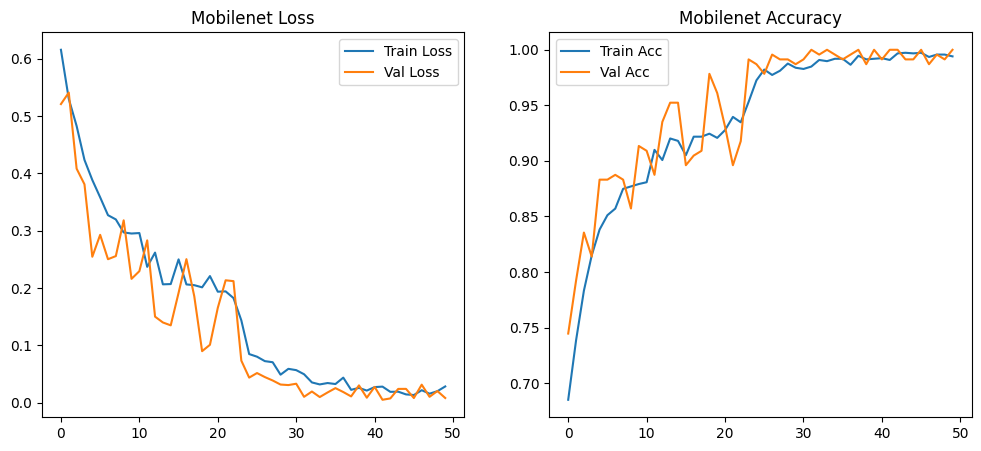

In [26]:
print("Training Mobilenet...")
mobilenet_model = get_model("mobilenet", num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
writer = SummaryWriter(log_dir=f"runs/mobilenet")
mobilenet_model, mobilenet_history = train_model(
    mobilenet_model, criterion, optimizer, scheduler,
    train_loader, val_loader, writer, num_epochs=50, model_name="mobilenet"
)
print("Model Training Completed.")
print("Training History:")
plot_curves(mobilenet_history, "Mobilenet")

Evaluating Mobilenet on Test Set:
Mobilenet Test Accuracy: 0.9957
Mobilenet Test Precision: 0.9960
Mobilenet Test Recall: 0.9955
Mobilenet Test F1-Score: 0.9957
Classification Report:
              precision    recall  f1-score   support

          no       1.00      0.99      1.00       110
         yes       0.99      1.00      1.00       123

    accuracy                           1.00       233
   macro avg       1.00      1.00      1.00       233
weighted avg       1.00      1.00      1.00       233



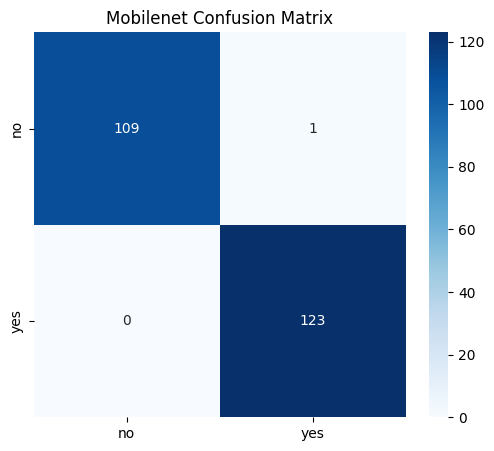

In [27]:
# Evaluating Mobilenet
print("Evaluating Mobilenet on Test Set:")
accuracy, precision, recall, f1 = evaluate_model(mobilenet_model, test_loader, "Mobilenet")
results["Model"].append("Mobilenet")
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)
results["F1-Score"].append(f1)

In [28]:
# Save the trained model
torch.save(mobilenet_model.state_dict(), "saved_models/mobilenet_model.pth")

In [29]:
# Clear GPU memory
torch.cuda.empty_cache()

### **Train VGG19**

Training VGG19...


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.1554, Train Acc=0.9380, Val Loss=0.1943, Val Acc=0.9221


Epoch 2/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.1529, Train Acc=0.9471, Val Loss=0.1310, Val Acc=0.9740


Epoch 3/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.1243, Train Acc=0.9595, Val Loss=0.0627, Val Acc=0.9784


Epoch 4/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.1597, Train Acc=0.9466, Val Loss=0.0770, Val Acc=0.9697


Epoch 5/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.1517, Train Acc=0.9477, Val Loss=0.2055, Val Acc=0.9177


Epoch 6/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.1189, Train Acc=0.9536, Val Loss=0.1526, Val Acc=0.9307


Epoch 7/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.1044, Train Acc=0.9617, Val Loss=0.0765, Val Acc=0.9784


Epoch 8/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.0542, Train Acc=0.9833, Val Loss=0.0376, Val Acc=0.9913


Epoch 9/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.0501, Train Acc=0.9865, Val Loss=0.0253, Val Acc=0.9913


Epoch 10/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.0308, Train Acc=0.9924, Val Loss=0.0233, Val Acc=0.9957


Epoch 11/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.0324, Train Acc=0.9876, Val Loss=0.0154, Val Acc=0.9957


Epoch 12/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.0195, Train Acc=0.9962, Val Loss=0.0115, Val Acc=0.9957


Epoch 13/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.0181, Train Acc=0.9951, Val Loss=0.0086, Val Acc=1.0000


Epoch 14/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.0149, Train Acc=0.9962, Val Loss=0.0246, Val Acc=0.9827


Epoch 15/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.0266, Train Acc=0.9898, Val Loss=0.0107, Val Acc=1.0000


Epoch 16/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.0222, Train Acc=0.9935, Val Loss=0.0091, Val Acc=1.0000


Epoch 17/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.0268, Train Acc=0.9951, Val Loss=0.0158, Val Acc=1.0000


Epoch 18/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.0122, Train Acc=0.9968, Val Loss=0.0069, Val Acc=1.0000


Epoch 19/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.0159, Train Acc=0.9941, Val Loss=0.0040, Val Acc=1.0000


Epoch 20/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.0110, Train Acc=0.9978, Val Loss=0.0057, Val Acc=1.0000


Epoch 21/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.0181, Train Acc=0.9968, Val Loss=0.0131, Val Acc=0.9957


Epoch 22/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.0095, Train Acc=0.9989, Val Loss=0.0089, Val Acc=1.0000


Epoch 23/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.0104, Train Acc=0.9978, Val Loss=0.0071, Val Acc=1.0000


Epoch 24/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 24: Train Loss=0.0145, Train Acc=0.9957, Val Loss=0.0096, Val Acc=1.0000


Epoch 25/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.0196, Train Acc=0.9968, Val Loss=0.0064, Val Acc=1.0000


Epoch 26/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 26: Train Loss=0.0185, Train Acc=0.9946, Val Loss=0.0116, Val Acc=0.9957


Epoch 27/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 27: Train Loss=0.0192, Train Acc=0.9957, Val Loss=0.0064, Val Acc=1.0000


Epoch 28/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 28: Train Loss=0.0116, Train Acc=0.9978, Val Loss=0.0057, Val Acc=1.0000


Epoch 29/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 29: Train Loss=0.0186, Train Acc=0.9941, Val Loss=0.0089, Val Acc=0.9957


Epoch 30/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 30: Train Loss=0.0304, Train Acc=0.9930, Val Loss=0.0117, Val Acc=1.0000


Epoch 31/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 31: Train Loss=0.0125, Train Acc=0.9968, Val Loss=0.0071, Val Acc=1.0000


Epoch 32/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 32: Train Loss=0.0190, Train Acc=0.9957, Val Loss=0.0078, Val Acc=1.0000


Epoch 33/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 33: Train Loss=0.0150, Train Acc=0.9973, Val Loss=0.0077, Val Acc=1.0000


Epoch 34/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 34: Train Loss=0.0089, Train Acc=0.9978, Val Loss=0.0122, Val Acc=1.0000


Epoch 35/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 35: Train Loss=0.0251, Train Acc=0.9941, Val Loss=0.0047, Val Acc=1.0000


Epoch 36/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 36: Train Loss=0.0119, Train Acc=0.9962, Val Loss=0.0101, Val Acc=1.0000


Epoch 37/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 37: Train Loss=0.0157, Train Acc=0.9946, Val Loss=0.0187, Val Acc=0.9957


Epoch 38/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 38: Train Loss=0.0093, Train Acc=0.9978, Val Loss=0.0045, Val Acc=1.0000


Epoch 39/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 39: Train Loss=0.0175, Train Acc=0.9951, Val Loss=0.0096, Val Acc=1.0000


Epoch 40/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 40: Train Loss=0.0203, Train Acc=0.9957, Val Loss=0.0129, Val Acc=0.9957


Epoch 41/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 41: Train Loss=0.0147, Train Acc=0.9957, Val Loss=0.0064, Val Acc=1.0000


Epoch 42/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 42: Train Loss=0.0129, Train Acc=0.9968, Val Loss=0.0102, Val Acc=1.0000


Epoch 43/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 43: Train Loss=0.0104, Train Acc=0.9978, Val Loss=0.0135, Val Acc=0.9957


Epoch 44/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 44: Train Loss=0.0227, Train Acc=0.9935, Val Loss=0.0048, Val Acc=1.0000


Epoch 45/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 45: Train Loss=0.0133, Train Acc=0.9962, Val Loss=0.0066, Val Acc=1.0000


Epoch 46/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 46: Train Loss=0.0110, Train Acc=0.9984, Val Loss=0.0076, Val Acc=1.0000


Epoch 47/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 47: Train Loss=0.0167, Train Acc=0.9973, Val Loss=0.0113, Val Acc=0.9957


Epoch 48/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 48: Train Loss=0.0178, Train Acc=0.9951, Val Loss=0.0074, Val Acc=1.0000


Epoch 49/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 49: Train Loss=0.0131, Train Acc=0.9957, Val Loss=0.0127, Val Acc=1.0000


Epoch 50/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 50: Train Loss=0.0218, Train Acc=0.9941, Val Loss=0.0087, Val Acc=1.0000
Model Training Completed.
Training History:


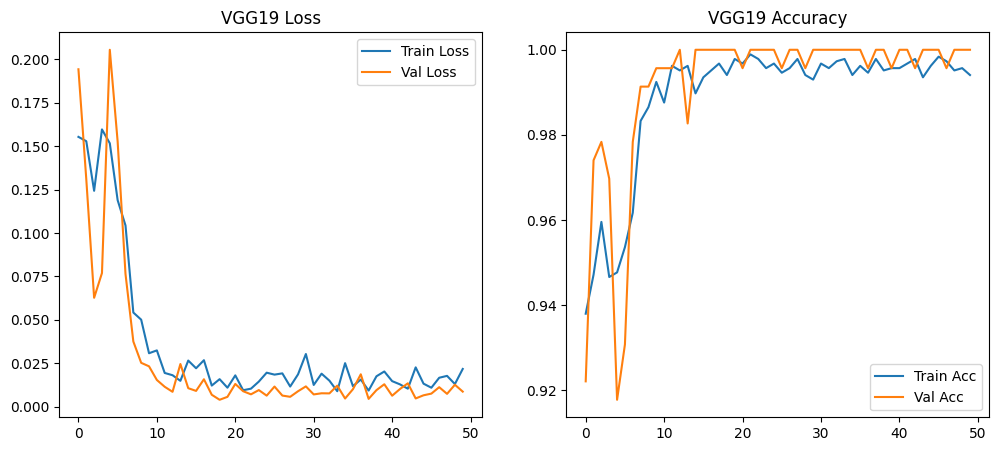

In [32]:
print("Training VGG19...")
vgg19_model = get_model("vgg19", num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
writer = SummaryWriter(log_dir=f"runs/vgg19")
mobilenet_model, mobilenet_history = train_model(
    mobilenet_model, criterion, optimizer, scheduler,
    train_loader, val_loader, writer, num_epochs=50, model_name="vgg19"
)
print("Model Training Completed.")
print("Training History:")
plot_curves(mobilenet_history, "VGG19")

Evaluating VGG19 on Test Set:
VGG19 Test Accuracy: 0.9957
VGG19 Test Precision: 0.9955
VGG19 Test Recall: 0.9959
VGG19 Test F1-Score: 0.9957
Classification Report:
              precision    recall  f1-score   support

          no       0.99      1.00      1.00       110
         yes       1.00      0.99      1.00       123

    accuracy                           1.00       233
   macro avg       1.00      1.00      1.00       233
weighted avg       1.00      1.00      1.00       233



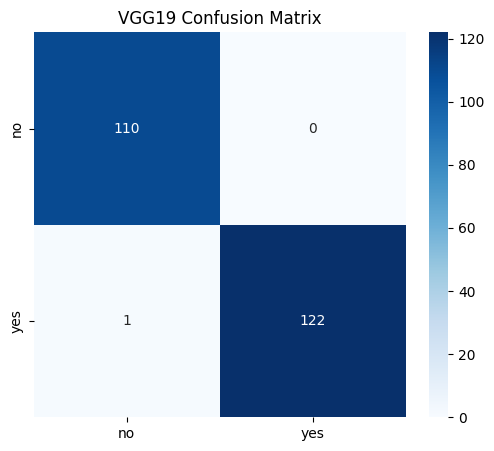

In [33]:
# Evaluating VGG19
print("Evaluating VGG19 on Test Set:")
accuracy, precision, recall, f1 = evaluate_model(mobilenet_model, test_loader, "VGG19")
results["Model"].append("VGG19")
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)
results["F1-Score"].append(f1)

In [34]:
# Save the trained model
torch.save(mobilenet_model.state_dict(), "saved_models/vgg19_model.pth")

In [35]:
# Clear GPU memory
torch.cuda.empty_cache()

### **Train Densenet**

Training Densenet...


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.5553, Train Acc=0.7287, Val Loss=0.5499, Val Acc=0.7056


Epoch 2/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.5103, Train Acc=0.7551, Val Loss=0.4053, Val Acc=0.7965


Epoch 3/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.4472, Train Acc=0.8042, Val Loss=0.4253, Val Acc=0.8009


Epoch 4/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.4521, Train Acc=0.8042, Val Loss=0.4456, Val Acc=0.8009


Epoch 5/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.4192, Train Acc=0.8166, Val Loss=0.5227, Val Acc=0.7576


Epoch 6/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.3679, Train Acc=0.8452, Val Loss=0.3859, Val Acc=0.8268


Epoch 7/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.3761, Train Acc=0.8403, Val Loss=0.2851, Val Acc=0.8615


Epoch 8/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.3769, Train Acc=0.8441, Val Loss=0.4082, Val Acc=0.8095


Epoch 9/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.3394, Train Acc=0.8614, Val Loss=0.2606, Val Acc=0.8658


Epoch 10/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.3469, Train Acc=0.8430, Val Loss=0.3015, Val Acc=0.8788


Epoch 11/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.3203, Train Acc=0.8738, Val Loss=0.2294, Val Acc=0.9134


Epoch 12/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.2815, Train Acc=0.8803, Val Loss=0.3301, Val Acc=0.8312


Epoch 13/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.3008, Train Acc=0.8749, Val Loss=0.1862, Val Acc=0.9481


Epoch 14/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.2303, Train Acc=0.9067, Val Loss=0.3319, Val Acc=0.8615


Epoch 15/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.2744, Train Acc=0.8910, Val Loss=0.2475, Val Acc=0.9048


Epoch 16/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.2777, Train Acc=0.8916, Val Loss=0.2489, Val Acc=0.9004


Epoch 17/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.2684, Train Acc=0.8959, Val Loss=0.1493, Val Acc=0.9567


Epoch 18/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.2313, Train Acc=0.9051, Val Loss=0.2223, Val Acc=0.8918


Epoch 19/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.2103, Train Acc=0.9121, Val Loss=0.1848, Val Acc=0.9134


Epoch 20/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.2399, Train Acc=0.9051, Val Loss=0.1940, Val Acc=0.9134


Epoch 21/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.2182, Train Acc=0.9169, Val Loss=0.2022, Val Acc=0.9177


Epoch 22/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.1802, Train Acc=0.9245, Val Loss=0.1372, Val Acc=0.9437


Epoch 23/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.1487, Train Acc=0.9450, Val Loss=0.1373, Val Acc=0.9567


Epoch 24/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 24: Train Loss=0.1497, Train Acc=0.9482, Val Loss=0.1324, Val Acc=0.9567


Epoch 25/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.1473, Train Acc=0.9471, Val Loss=0.1300, Val Acc=0.9437


Epoch 26/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 26: Train Loss=0.1062, Train Acc=0.9687, Val Loss=0.1153, Val Acc=0.9437


Epoch 27/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 27: Train Loss=0.1137, Train Acc=0.9585, Val Loss=0.1005, Val Acc=0.9610


Epoch 28/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 28: Train Loss=0.1145, Train Acc=0.9617, Val Loss=0.0951, Val Acc=0.9567


Epoch 29/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 29: Train Loss=0.1031, Train Acc=0.9633, Val Loss=0.0945, Val Acc=0.9697


Epoch 30/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 30: Train Loss=0.1015, Train Acc=0.9720, Val Loss=0.0955, Val Acc=0.9524


Epoch 31/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 31: Train Loss=0.0918, Train Acc=0.9649, Val Loss=0.0694, Val Acc=0.9740


Epoch 32/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 32: Train Loss=0.0831, Train Acc=0.9736, Val Loss=0.0944, Val Acc=0.9697


Epoch 33/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 33: Train Loss=0.0994, Train Acc=0.9703, Val Loss=0.0686, Val Acc=0.9740


Epoch 34/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 34: Train Loss=0.0855, Train Acc=0.9693, Val Loss=0.0580, Val Acc=0.9740


Epoch 35/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 35: Train Loss=0.0810, Train Acc=0.9752, Val Loss=0.0491, Val Acc=0.9913


Epoch 36/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 36: Train Loss=0.0839, Train Acc=0.9741, Val Loss=0.0561, Val Acc=0.9697


Epoch 37/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 37: Train Loss=0.0670, Train Acc=0.9795, Val Loss=0.0380, Val Acc=0.9913


Epoch 38/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 38: Train Loss=0.0649, Train Acc=0.9806, Val Loss=0.0413, Val Acc=0.9827


Epoch 39/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 39: Train Loss=0.0498, Train Acc=0.9849, Val Loss=0.0276, Val Acc=0.9957


Epoch 40/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 40: Train Loss=0.0575, Train Acc=0.9822, Val Loss=0.0563, Val Acc=0.9827


Epoch 41/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 41: Train Loss=0.0739, Train Acc=0.9746, Val Loss=0.0383, Val Acc=0.9870


Epoch 42/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 42: Train Loss=0.0497, Train Acc=0.9827, Val Loss=0.0256, Val Acc=0.9957


Epoch 43/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 43: Train Loss=0.0521, Train Acc=0.9849, Val Loss=0.0513, Val Acc=0.9784


Epoch 44/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 44: Train Loss=0.0497, Train Acc=0.9817, Val Loss=0.0220, Val Acc=1.0000


Epoch 45/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 45: Train Loss=0.0647, Train Acc=0.9817, Val Loss=0.0219, Val Acc=0.9957


Epoch 46/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 46: Train Loss=0.0434, Train Acc=0.9876, Val Loss=0.0300, Val Acc=0.9913


Epoch 47/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 47: Train Loss=0.0603, Train Acc=0.9806, Val Loss=0.0339, Val Acc=0.9870


Epoch 48/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 48: Train Loss=0.0436, Train Acc=0.9881, Val Loss=0.0251, Val Acc=0.9957


Epoch 49/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 49: Train Loss=0.0466, Train Acc=0.9887, Val Loss=0.0332, Val Acc=0.9913


Epoch 50/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 50: Train Loss=0.0370, Train Acc=0.9892, Val Loss=0.0240, Val Acc=1.0000
Model Training Completed.
Training History:


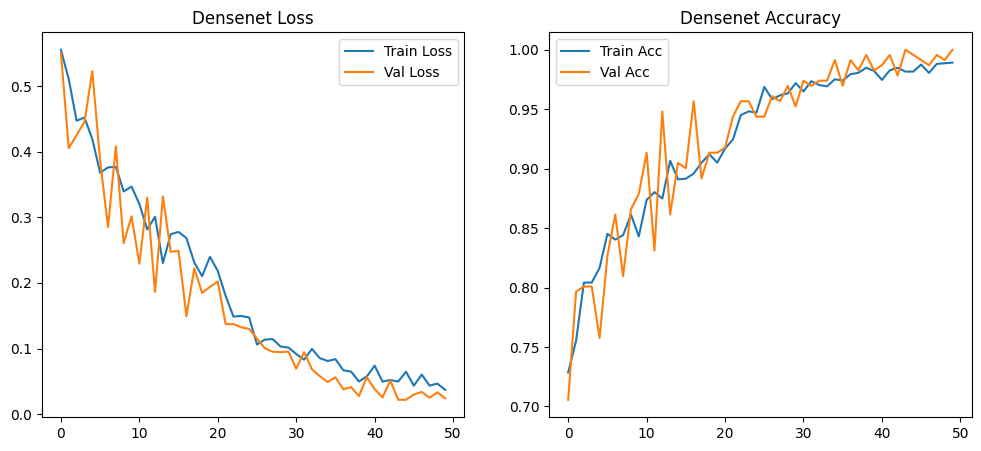

In [36]:
# Training Densenet
print("Training Densenet...")
densenet_model = get_model("densenet", num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
writer = SummaryWriter(log_dir=f"runs/densenet")
densenet_model, densenet_history = train_model(
    densenet_model, criterion, optimizer, scheduler,
    train_loader, val_loader, writer, num_epochs=50, model_name="densenet"
)
print("Model Training Completed.")
print("Training History:")
plot_curves(densenet_history, "Densenet")

Evaluating Densenet on Test Set:
Densenet Test Accuracy: 0.9914
Densenet Test Precision: 0.9911
Densenet Test Recall: 0.9919
Densenet Test F1-Score: 0.9914
Classification Report:
              precision    recall  f1-score   support

          no       0.98      1.00      0.99       110
         yes       1.00      0.98      0.99       123

    accuracy                           0.99       233
   macro avg       0.99      0.99      0.99       233
weighted avg       0.99      0.99      0.99       233



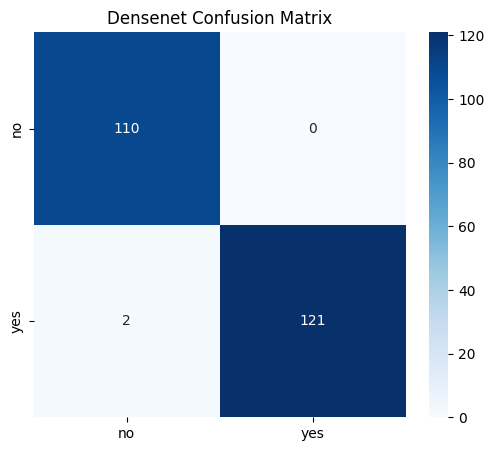

In [37]:
# Evaluating Densenet
print("Evaluating Densenet on Test Set:")
accuracy, precision, recall, f1 = evaluate_model(densenet_model, test_loader, "Densenet")
results["Model"].append("Densenet")
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)
results["F1-Score"].append(f1)

In [38]:
# Save the trained model
torch.save(densenet_model.state_dict(), "saved_models/densnet_model.pth")

In [39]:
# Clear GPU memory
torch.cuda.empty_cache()

### **Train Resnet**

Training Resnet...


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.7274, Train Acc=0.6510, Val Loss=0.6380, Val Acc=0.6537


Epoch 2/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.5694, Train Acc=0.7422, Val Loss=0.9685, Val Acc=0.7965


Epoch 3/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.5627, Train Acc=0.7168, Val Loss=1.7507, Val Acc=0.6580


Epoch 4/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.5656, Train Acc=0.7211, Val Loss=0.4807, Val Acc=0.7706


Epoch 5/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.5453, Train Acc=0.7395, Val Loss=0.7960, Val Acc=0.6104


Epoch 6/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.5258, Train Acc=0.7594, Val Loss=0.5031, Val Acc=0.7879


Epoch 7/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.5169, Train Acc=0.7551, Val Loss=0.4221, Val Acc=0.8312


Epoch 8/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.4532, Train Acc=0.8020, Val Loss=0.4436, Val Acc=0.7835


Epoch 9/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.4466, Train Acc=0.7988, Val Loss=0.3798, Val Acc=0.8398


Epoch 10/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.4475, Train Acc=0.7999, Val Loss=0.3500, Val Acc=0.8312


Epoch 11/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.4310, Train Acc=0.8139, Val Loss=0.4413, Val Acc=0.8052


Epoch 12/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.4206, Train Acc=0.8101, Val Loss=0.4234, Val Acc=0.8095


Epoch 13/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.3904, Train Acc=0.8328, Val Loss=0.6062, Val Acc=0.8009


Epoch 14/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.3874, Train Acc=0.8296, Val Loss=0.6012, Val Acc=0.8615


Epoch 15/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.3244, Train Acc=0.8587, Val Loss=0.2761, Val Acc=0.8874


Epoch 16/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.2744, Train Acc=0.8824, Val Loss=0.2219, Val Acc=0.9177


Epoch 17/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.2674, Train Acc=0.8932, Val Loss=0.2424, Val Acc=0.8831


Epoch 18/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.2582, Train Acc=0.8959, Val Loss=0.1755, Val Acc=0.9307


Epoch 19/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.2593, Train Acc=0.8900, Val Loss=0.2143, Val Acc=0.9048


Epoch 20/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.2594, Train Acc=0.8905, Val Loss=0.1422, Val Acc=0.9610


Epoch 21/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.2257, Train Acc=0.9105, Val Loss=0.1514, Val Acc=0.9437


Epoch 22/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.2149, Train Acc=0.9196, Val Loss=0.1835, Val Acc=0.9177


Epoch 23/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.1953, Train Acc=0.9191, Val Loss=0.1415, Val Acc=0.9524


Epoch 24/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 24: Train Loss=0.2035, Train Acc=0.9196, Val Loss=0.1320, Val Acc=0.9654


Epoch 25/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.1860, Train Acc=0.9293, Val Loss=0.1395, Val Acc=0.9394


Epoch 26/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 26: Train Loss=0.1844, Train Acc=0.9293, Val Loss=0.1390, Val Acc=0.9524


Epoch 27/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 27: Train Loss=0.1807, Train Acc=0.9239, Val Loss=0.1406, Val Acc=0.9394


Epoch 28/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 28: Train Loss=0.1721, Train Acc=0.9331, Val Loss=0.1253, Val Acc=0.9567


Epoch 29/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 29: Train Loss=0.1611, Train Acc=0.9364, Val Loss=0.1395, Val Acc=0.9351


Epoch 30/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 30: Train Loss=0.1564, Train Acc=0.9423, Val Loss=0.1632, Val Acc=0.9264


Epoch 31/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 31: Train Loss=0.1364, Train Acc=0.9504, Val Loss=0.1025, Val Acc=0.9610


Epoch 32/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 32: Train Loss=0.1611, Train Acc=0.9428, Val Loss=0.1020, Val Acc=0.9610


Epoch 33/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 33: Train Loss=0.1178, Train Acc=0.9579, Val Loss=0.1140, Val Acc=0.9567


Epoch 34/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 34: Train Loss=0.1365, Train Acc=0.9498, Val Loss=0.1501, Val Acc=0.9394


Epoch 35/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 35: Train Loss=0.1192, Train Acc=0.9542, Val Loss=0.1149, Val Acc=0.9567


Epoch 36/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 36: Train Loss=0.1289, Train Acc=0.9482, Val Loss=0.0848, Val Acc=0.9740


Epoch 37/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 37: Train Loss=0.1323, Train Acc=0.9520, Val Loss=0.0917, Val Acc=0.9740


Epoch 38/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 38: Train Loss=0.1178, Train Acc=0.9574, Val Loss=0.3029, Val Acc=0.8788


Epoch 39/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 39: Train Loss=0.1064, Train Acc=0.9612, Val Loss=0.0891, Val Acc=0.9610


Epoch 40/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 40: Train Loss=0.0981, Train Acc=0.9617, Val Loss=0.0861, Val Acc=0.9697


Epoch 41/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 41: Train Loss=0.1108, Train Acc=0.9569, Val Loss=0.1074, Val Acc=0.9524


Epoch 42/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 42: Train Loss=0.0779, Train Acc=0.9752, Val Loss=0.0879, Val Acc=0.9610


Epoch 43/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 43: Train Loss=0.0746, Train Acc=0.9736, Val Loss=0.0610, Val Acc=0.9784


Epoch 44/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 44: Train Loss=0.0551, Train Acc=0.9822, Val Loss=0.0489, Val Acc=0.9870


Epoch 45/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 45: Train Loss=0.0651, Train Acc=0.9795, Val Loss=0.0519, Val Acc=0.9827


Epoch 46/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 46: Train Loss=0.0722, Train Acc=0.9768, Val Loss=0.0547, Val Acc=0.9870


Epoch 47/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 47: Train Loss=0.0613, Train Acc=0.9806, Val Loss=0.0772, Val Acc=0.9784


Epoch 48/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 48: Train Loss=0.0554, Train Acc=0.9822, Val Loss=0.0447, Val Acc=0.9870


Epoch 49/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 49: Train Loss=0.0603, Train Acc=0.9795, Val Loss=0.0422, Val Acc=0.9827


Epoch 50/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 50: Train Loss=0.0622, Train Acc=0.9800, Val Loss=0.0430, Val Acc=0.9913
Model Training Completed.
Training History:


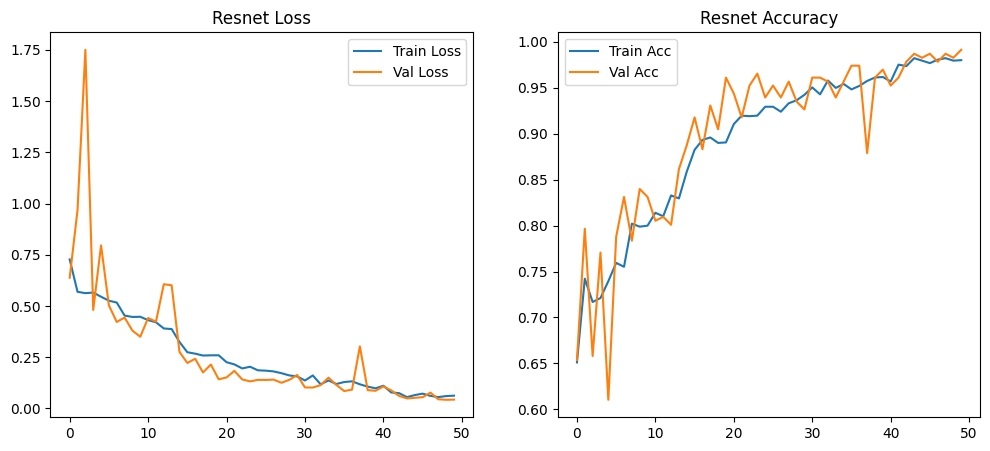

In [40]:
# Training Resnet
print("Training Resnet...")
resnet_model = get_model("resnet", num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
writer = SummaryWriter(log_dir=f"runs/resnet")
resnet_model, resnet_history = train_model(
    resnet_model, criterion, optimizer, scheduler,
    train_loader, val_loader, writer, num_epochs=50, model_name="resnet"
)
print("Model Training Completed.")
print("Training History:")
plot_curves(resnet_history, "Resnet")

Evaluating Resnet on Test Set:
Resnet Test Accuracy: 0.9828
Resnet Test Precision: 0.9825
Resnet Test Recall: 0.9837
Resnet Test F1-Score: 0.9828
Classification Report:
              precision    recall  f1-score   support

          no       0.96      1.00      0.98       110
         yes       1.00      0.97      0.98       123

    accuracy                           0.98       233
   macro avg       0.98      0.98      0.98       233
weighted avg       0.98      0.98      0.98       233



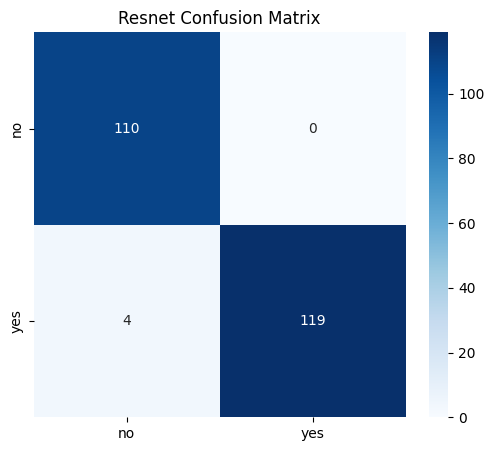

In [41]:
# Evaluating Resnet
print("Evaluating Resnet on Test Set:")
accuracy, precision, recall, f1 = evaluate_model(resnet_model, test_loader, "Resnet")
results["Model"].append("Resnet")
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)
results["F1-Score"].append(f1)

In [42]:
# Save the trained model
torch.save(resnet_model.state_dict(), "saved_models/resnet_model.pth")

### **Train ViT**

Training ViT...


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.8174, Train Acc=0.5631, Val Loss=0.6393, Val Acc=0.6797


Epoch 2/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.7442, Train Acc=0.5178, Val Loss=0.6848, Val Acc=0.5801


Epoch 3/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.6936, Train Acc=0.5663, Val Loss=0.6211, Val Acc=0.6667


Epoch 4/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.6713, Train Acc=0.5955, Val Loss=0.6004, Val Acc=0.6926


Epoch 5/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.6501, Train Acc=0.6332, Val Loss=0.5701, Val Acc=0.7056


Epoch 6/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.6426, Train Acc=0.6472, Val Loss=0.5485, Val Acc=0.7403


Epoch 7/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.6412, Train Acc=0.6532, Val Loss=0.6068, Val Acc=0.6667


Epoch 8/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.6185, Train Acc=0.6650, Val Loss=0.5246, Val Acc=0.7229


Epoch 9/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.6361, Train Acc=0.6645, Val Loss=0.5527, Val Acc=0.7316


Epoch 10/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.6293, Train Acc=0.6451, Val Loss=0.5572, Val Acc=0.7186


Epoch 11/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.6299, Train Acc=0.6462, Val Loss=0.5753, Val Acc=0.6970


Epoch 12/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.6062, Train Acc=0.6877, Val Loss=0.5549, Val Acc=0.7619


Epoch 13/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.5644, Train Acc=0.7184, Val Loss=0.5028, Val Acc=0.7532


Epoch 14/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.5199, Train Acc=0.7406, Val Loss=0.4609, Val Acc=0.7532


Epoch 15/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.5019, Train Acc=0.7643, Val Loss=0.4444, Val Acc=0.7792


Epoch 16/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.4774, Train Acc=0.7778, Val Loss=0.4451, Val Acc=0.7965


Epoch 17/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.4732, Train Acc=0.7843, Val Loss=0.4450, Val Acc=0.7965


Epoch 18/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.4601, Train Acc=0.7929, Val Loss=0.4540, Val Acc=0.7619


Epoch 19/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.4482, Train Acc=0.7929, Val Loss=0.4443, Val Acc=0.7835


Epoch 20/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.4318, Train Acc=0.8031, Val Loss=0.4391, Val Acc=0.7619


Epoch 21/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.4125, Train Acc=0.8161, Val Loss=0.3985, Val Acc=0.8225


Epoch 22/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.4225, Train Acc=0.8172, Val Loss=0.4469, Val Acc=0.8009


Epoch 23/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.4029, Train Acc=0.8274, Val Loss=0.3615, Val Acc=0.8268


Epoch 24/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 24: Train Loss=0.4044, Train Acc=0.8317, Val Loss=0.3892, Val Acc=0.8312


Epoch 25/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.4044, Train Acc=0.8263, Val Loss=0.4127, Val Acc=0.8225


Epoch 26/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 26: Train Loss=0.3766, Train Acc=0.8414, Val Loss=0.3760, Val Acc=0.8268


Epoch 27/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 27: Train Loss=0.3810, Train Acc=0.8479, Val Loss=0.3854, Val Acc=0.8052


Epoch 28/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 28: Train Loss=0.3578, Train Acc=0.8463, Val Loss=0.3744, Val Acc=0.8312


Epoch 29/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 29: Train Loss=0.3631, Train Acc=0.8479, Val Loss=0.3434, Val Acc=0.8745


Epoch 30/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 30: Train Loss=0.3578, Train Acc=0.8479, Val Loss=0.3928, Val Acc=0.8182


Epoch 31/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 31: Train Loss=0.3615, Train Acc=0.8511, Val Loss=0.3726, Val Acc=0.8268


Epoch 32/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 32: Train Loss=0.3496, Train Acc=0.8625, Val Loss=0.3957, Val Acc=0.8139


Epoch 33/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 33: Train Loss=0.3533, Train Acc=0.8565, Val Loss=0.3408, Val Acc=0.8571


Epoch 34/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 34: Train Loss=0.3485, Train Acc=0.8581, Val Loss=0.3807, Val Acc=0.8355


Epoch 35/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 35: Train Loss=0.3566, Train Acc=0.8484, Val Loss=0.3395, Val Acc=0.8442


Epoch 36/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 36: Train Loss=0.3658, Train Acc=0.8474, Val Loss=0.3700, Val Acc=0.8485


Epoch 37/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 37: Train Loss=0.3520, Train Acc=0.8549, Val Loss=0.4147, Val Acc=0.8139


Epoch 38/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 38: Train Loss=0.3365, Train Acc=0.8581, Val Loss=0.3578, Val Acc=0.8268


Epoch 39/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 39: Train Loss=0.3403, Train Acc=0.8630, Val Loss=0.3868, Val Acc=0.8485


Epoch 40/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 40: Train Loss=0.3395, Train Acc=0.8635, Val Loss=0.3637, Val Acc=0.8528


Epoch 41/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 41: Train Loss=0.3568, Train Acc=0.8560, Val Loss=0.3356, Val Acc=0.8701


Epoch 42/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 42: Train Loss=0.3388, Train Acc=0.8662, Val Loss=0.3852, Val Acc=0.8398


Epoch 43/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 43: Train Loss=0.3519, Train Acc=0.8522, Val Loss=0.3799, Val Acc=0.8355


Epoch 44/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 44: Train Loss=0.3363, Train Acc=0.8727, Val Loss=0.3417, Val Acc=0.8442


Epoch 45/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 45: Train Loss=0.3320, Train Acc=0.8706, Val Loss=0.3545, Val Acc=0.8701


Epoch 46/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 46: Train Loss=0.3245, Train Acc=0.8689, Val Loss=0.3474, Val Acc=0.8485


Epoch 47/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 47: Train Loss=0.3359, Train Acc=0.8592, Val Loss=0.3896, Val Acc=0.8182


Epoch 48/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 48: Train Loss=0.3455, Train Acc=0.8603, Val Loss=0.3689, Val Acc=0.8442


Epoch 49/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 49: Train Loss=0.3385, Train Acc=0.8668, Val Loss=0.3635, Val Acc=0.8398


Epoch 50/50 Batches:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 50: Train Loss=0.3360, Train Acc=0.8598, Val Loss=0.3554, Val Acc=0.8225
Model Training Completed.
Training History:


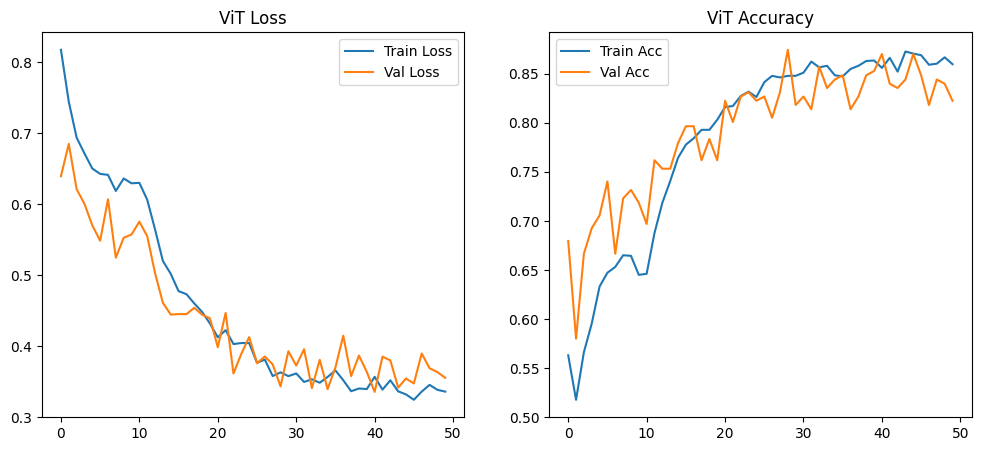

In [43]:
# Training vit
print("Training ViT...")
vit_model = get_model("vit", num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
writer = SummaryWriter(log_dir=f"runs/vit")
vit_model, vit_history = train_model(
    vit_model, criterion, optimizer, scheduler,
    train_loader, val_loader, writer, num_epochs=50, model_name="vit"
)
print("Model Training Completed.")
print("Training History:")
plot_curves(vit_history, "ViT")

Evaluating ViT on Test Set:
ViT Test Accuracy: 0.8584
ViT Test Precision: 0.8624
ViT Test Recall: 0.8553
ViT Test F1-Score: 0.8569
Classification Report:
              precision    recall  f1-score   support

          no       0.89      0.80      0.84       110
         yes       0.84      0.91      0.87       123

    accuracy                           0.86       233
   macro avg       0.86      0.86      0.86       233
weighted avg       0.86      0.86      0.86       233



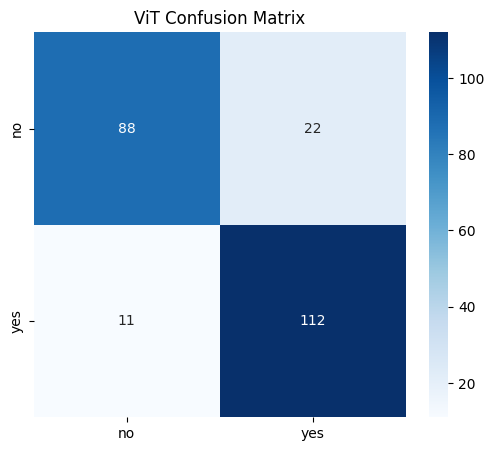

In [44]:
# Evaluating ViT
print("Evaluating ViT on Test Set:")
accuracy, precision, recall, f1 = evaluate_model(vit_model, test_loader, "ViT")
results["Model"].append("ViT")
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)
results["F1-Score"].append(f1)

In [45]:
# Save the trained model
torch.save(vit_model.state_dict(), "saved_models/vit_model.pth")

In [46]:
# Clear GPU memory
torch.cuda.empty_cache()

### **Evaluation Summary**

In [47]:
results_df = pd.DataFrame(results)
print("Evaluation Summary:")
results_df

Evaluation Summary:


,Model,Accuracy,Precision,Recall,F1-Score
0,Mobilenet,0.995708,0.995968,0.995455,0.995693
1,VGG19,0.995708,0.995495,0.995935,0.995697
2,Densenet,0.991416,0.991071,0.991870,0.991397
3,Resnet,0.982833,0.982456,0.983740,0.982807
4,ViT,0.858369,0.862355,0.855285,0.856850


In [48]:
# Save the summay results to a CSV file
results_df.to_csv("results/model_evaluation_summary.csv", index=False)